
# Project Milestone One: Forming Your Team, Understanding the Problem, and Exploring the Data

#### **Due:** Midnight on October 26th (with 2-hour grace period) - **worth 25 points**

> **Note:** Because we must begin manual grading immediately, there will be *no* late period for this milestone.

This milestone is the first phase of your project. You'll begin working in teams, select your dataset, perform basic exploratory data analysis (EDA), and frame your classification problem.  

1. **Form your project team.**  
   Convene your team and complete the **Team Contract** (available in your Homework Repository). This was **due on October 19th** at midnight (along with Homework 07). Each member must review and sign it before submission.

2. **Select a team leader.**  
   Choose one team member to act as the **Gradescope submitter** for your team. The entire team should collaborate on the notebook, but only the leader will submit.

3. **Explore your dataset and frame your task.**  
   You'll work through the notebook to  
   - Examine the provided dataset,  
   - Be able to describe the classification problem you'll be solving in business or applied terms,
   - Conduct basic EDA to understand its structure and challenges, and
   - Spot potential challenges, propose solutions, and select appropriate performance metrics.  

This milestone focuses on understanding your data and clearly articulating what your model will eventually predict. You are not required to build a model yet (that will happen in Milestone 2) but of course you have lots of example models to choose from previous Homeworks and Coding Notebooks and you may wish to explore a baseline model as you do this first phase of your project.


### The Dataset

The final project is a **classification task** using the **Food-101 (Images)** dataset.

#### **Food-101 (Images)**  
A web-scraped collection of approximately **101,000 color photos** across **101 food categories** (~1,000 images per class).  
Images vary widely in **lighting, composition, and color balance**, making this dataset excellent for practicing **data cleaning**, **EDA**, and **augmentation** techniques such as random crops, flips, and color jitter.


### What To Do

We've provided template code to start your project:

* **Download** the dataset.
* **Visualize** a few representative samples.

In the sections that follow:

* **Problem One - Exploratory Data Analysis (EDA):**
  Quantify scale and structure, check class balance, and note any missing/duplicate or inconsistent entries.

* **Problem Two - Challenges & Solution Paths:**
  Identify likely issues (e.g., overlapping categories, imbalanced labels, data-quality problems, length/size variance) and outline practical remedies you would try. *(No model training required.)*

For tips on working with **Hugging Face Datasets** (helpful for large datasets), see the **Appendix**.


In [1]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [2]:
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

## Prelude: Food-101 Dataset

We have selected the **Food-101 (images)** dataset for this project. This dataset contains 101 classes of web photos with **inconsistent lighting, white balance, color casts, and composition** (plus varying resolutions). These natural quirks make augmentation and input-pipeline choices meaningful.

> **Note:** We use Hugging Face **Dataset/DatasetDict** objects (table-like datasets), not NumPy/Pandas arrays. Most of what you need to know is contained in the template code, but see the **Appendix** for more information on HG Datasets.

---

### Food-101 Dataset

#### **Load Food-101 as a Dataset**

> Note: this loads a **Hugging Face `Dataset`**, not NumPy or TensorFlow tensors.
> Each sample is stored as a **dictionary** with two keys - `"image"` (a PIL image object) and `"label"` (an integer class ID).
> You can access columns by name, e.g. `food_all["image"]` or `food_all["label"]`, and check the dataset size with `len(food_all)`.
> Unlike arrays, image sizes and aspect ratios may differ across samples - you'll handle resizing or normalization later during preprocessing.

In [3]:
food_all = load_dataset("food101", split="train+validation")  # ~101k images total
label_col = "label"

# Sanity check the label column
assert label_col in food_all.features
assert isinstance(food_all.features[label_col], ClassLabel)

food_label_names = food_all.features[label_col].names
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

Total images: 101,000  |  Classes: 101


#### **Quick sanity checks (rows, label ids, a few image sizes)**

In [4]:
# First 5 rows: label id -> name
for i in range(5):
    y = food_all[i][label_col]
    print(f"row {i}: id={y}, name={food_label_names[y]}")

labels_list = list(food_all[label_col])
print("labels length:", len(labels_list), "unique classes:", len(set(labels_list)))
print("min/max label IDs:", min(labels_list), max(labels_list))

for i in range(3):
    print(f"image {i} size:", food_all[i]["image"].size)  # (W, H)

row 0: id=6, name=beignets
row 1: id=6, name=beignets
row 2: id=6, name=beignets
row 3: id=6, name=beignets
row 4: id=6, name=beignets
labels length: 101000 unique classes: 101
min/max label IDs: 0 100
image 0 size: (384, 512)
image 1 size: (512, 512)
image 2 size: (512, 383)
labels length: 101000 unique classes: 101
min/max label IDs: 0 100
image 0 size: (384, 512)
image 1 size: (512, 512)
image 2 size: (512, 383)


#### **Visual preview: random 3x3 grid from TRAIN**

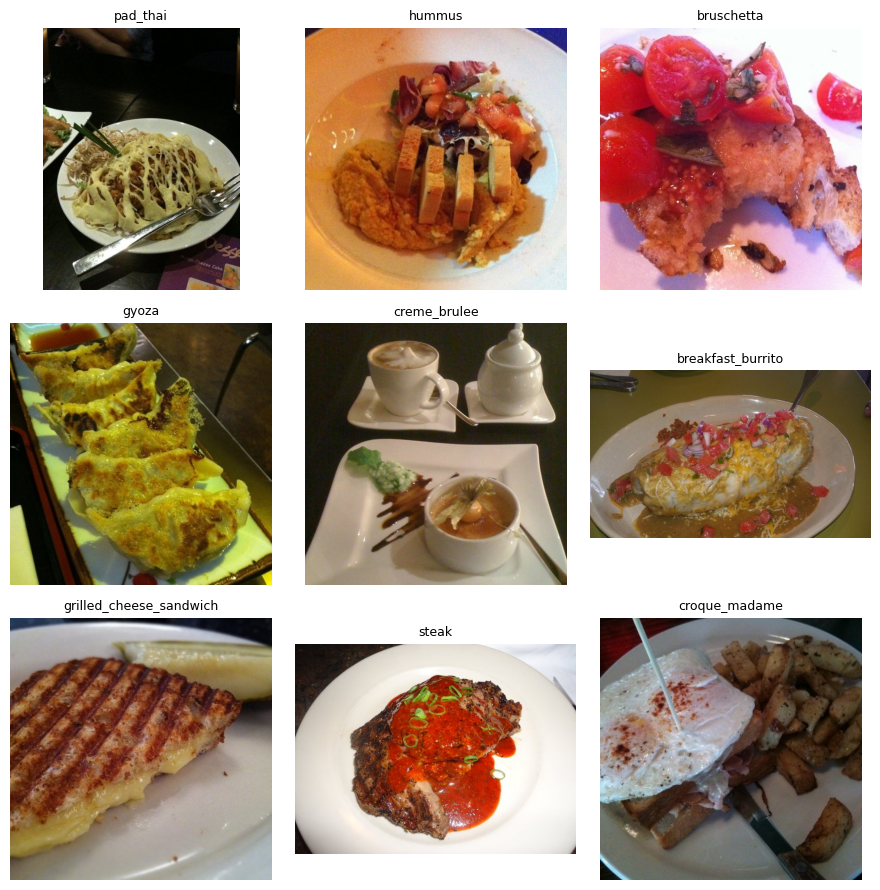

In [5]:
n, cols, seed = 9, 3, 42
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()

---

## Problem 1 - Exploratory Data Analysis (10 pts)

#### Objective
In this problem, you will explore the Food-101 dataset through basic exploratory data analysis (EDA).  
Your goal is to understand the structure, content, and challenges of the dataset.  
By the end of this section, you should be able to explain what makes the dataset interesting, identify potential modeling challenges (e.g., imbalance, ambiguity, quality issues), and justify why it is a good choice for your classification project.


#### What to Do
1. **Load and examine the dataset** using the provided template code.  
   Understand the basic structure and properties of the Food-101 dataset.

2. **Inspect** the dataset's basic properties:  
   - **Number of samples and classes:**  
     Determine how many total examples and distinct categories are present. Verify that the counts match expectations (101 food classes).  
   - **Example records or images:**  
     View several samples to understand the input format, diversity, and potential quality issues.  
     Note lighting or composition differences.
   - **Distribution of labels (check for imbalance):**  
     Plot or tabulate label frequencies to see whether some classes dominate. Imbalanced datasets can bias model training and may require special handling.  
   - **Missing or inconsistent data:**  
     Look for empty fields, unreadable images, duplicate entries, or mislabeled samples. Handle or document any issues you find.  
   - **Overlapping or ambiguous class labels:**  
     Identify categories that may not be clearly distinct - e.g., "apple pie" vs. "cheesecake."  
     Ambiguity in labels can increase confusion between classes and reduce model accuracy.

3. **Visualize key aspects:**  
   Extend the template code to complete the EDA for the Food-101 dataset:  
   - Create visual summaries to better understand the data (some are implemented in the template code).  
   - Verify that the dataset is balanced across classes.  
   - Display a small grid of random images to check variation in appearance, composition, and background (done in template code).  
   - Compare image sizes to determine whether resizing or normalization will be needed.  
   - Examine lighting and color balance - many web-scraped photos vary widely in brightness, saturation, and white balance.  

4. **Answer the graded questions below.**


In [6]:
# Count the number of samples per class in the Food-101 dataset
label_counts = Counter(food_all[label_col])

# Display the class names and their counts
print("Class counts:")
for label_id, count in sorted(label_counts.items()):
    print(f"  {food_label_names[label_id]}: {count} samples")


Class counts:
  apple_pie: 1000 samples
  baby_back_ribs: 1000 samples
  baklava: 1000 samples
  beef_carpaccio: 1000 samples
  beef_tartare: 1000 samples
  beet_salad: 1000 samples
  beignets: 1000 samples
  bibimbap: 1000 samples
  bread_pudding: 1000 samples
  breakfast_burrito: 1000 samples
  bruschetta: 1000 samples
  caesar_salad: 1000 samples
  cannoli: 1000 samples
  caprese_salad: 1000 samples
  carrot_cake: 1000 samples
  ceviche: 1000 samples
  cheesecake: 1000 samples
  cheese_plate: 1000 samples
  chicken_curry: 1000 samples
  chicken_quesadilla: 1000 samples
  chicken_wings: 1000 samples
  chocolate_cake: 1000 samples
  chocolate_mousse: 1000 samples
  churros: 1000 samples
  clam_chowder: 1000 samples
  club_sandwich: 1000 samples
  crab_cakes: 1000 samples
  creme_brulee: 1000 samples
  croque_madame: 1000 samples
  cup_cakes: 1000 samples
  deviled_eggs: 1000 samples
  donuts: 1000 samples
  dumplings: 1000 samples
  edamame: 1000 samples
  eggs_benedict: 1000 samples


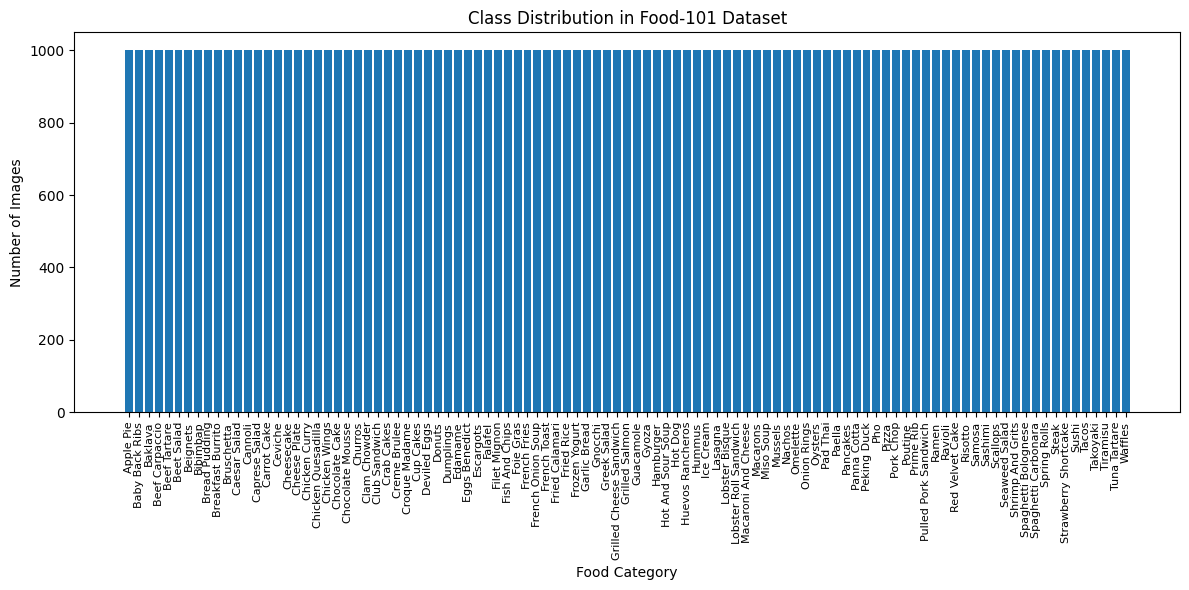

In [7]:
# Create a bar plot of the class distribution
plt.figure(figsize=(12, 6))
# Format labels: capitalize and replace underscores with spaces
formatted_labels = [food_label_names[i].replace('_', ' ').title() for i in range(len(label_counts))]
plt.bar(range(len(label_counts)), list(label_counts.values()), tick_label=formatted_labels)
plt.xlabel("Food Category")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Food-101 Dataset")
plt.xticks(rotation=90, fontsize=8) # Rotate labels 90 degrees for visibility with smaller font
plt.tight_layout() # Adjust layout to prevent label cutoff
plt.show()

In [ ]:
print('Number of food items:',len(label_counts.items()))

Number of food items: 101


: 

In [ ]:
# Data Quality Check: Missing, Corrupted, or Inconsistent Data
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

# Check for missing or null data
print(f"\n1. Missing Data Analysis:")
print(f"   Total samples in dataset: {len(food_all):,}")
print(f"   Samples with valid labels: {len([x for x in food_all if x['label'] is not None]):,}")
print(f"   Samples with valid images: {len([x for x in food_all if x['image'] is not None]):,}")

# Verify label integrity
labels_valid = all(0 <= x['label'] <= 100 for x in food_all)
print(f"\n2. Label Integrity:")
print(f"   All labels in valid range (0-100): {labels_valid}")
print(f"   Label range: {min(food_all['label'])} to {max(food_all['label'])}")

# Check for potential duplicates or data issues
print(f"\n3. Data Consistency:")
print(f"   Expected classes: 101")
print(f"   Actual unique classes found: {len(set(food_all['label']))}")
print(f"   Expected samples per class: 1,000")
print(f"   Actual min/max per class: {min(label_counts.values()):,} / {max(label_counts.values()):,}")

# Summary
issues_found = []
if len(food_all) != len([x for x in food_all if x['label'] is not None]):
    issues_found.append("Missing labels detected")
if len(food_all) != len([x for x in food_all if x['image'] is not None]):
    issues_found.append("Missing images detected")
if not labels_valid:
    issues_found.append("Invalid label values detected")

print(f"\n4. Summary:")
if len(issues_found) == 0:
    print(f"No data quality issues detected!")
    print(f"Dataset is clean and ready for modeling")
else:
    print(f"Issues found:")
    for issue in issues_found:
        print(f" - {issue}")

print("=" * 60)


DATA QUALITY CHECK

1. Missing Data Analysis:
   Total samples in dataset: 101,000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
import random
import numpy as np

# Select random indices
num_samples = 5000
random_indices = random.sample(range(len(food_all['image'])), num_samples)

width_size=[]
height_size=[]

# Iterate over the selected random indices
for i in random_indices:
    width_size.append(food_all[i]["image"].size[0]) # Append width
    height_size.append(food_all[i]["image"].size[1]) # Append height

# Optional: print some stats about the image sizes
print(f"Number of sampled images: {num_samples}")
print(f"Average width: {np.mean(width_size):.2f}")
print(f"Average height: {np.mean(height_size):.2f}")
print(f"Min width: {np.min(width_size)}, Max width: {np.max(width_size)}")
print(f"Min height: {np.min(height_size)}, Max height: {np.max(height_size)}")

Number of sampled images: 5000
Average width: 495.24
Average height: 475.41
Min width: 242, Max width: 512
Min height: 239, Max height: 512


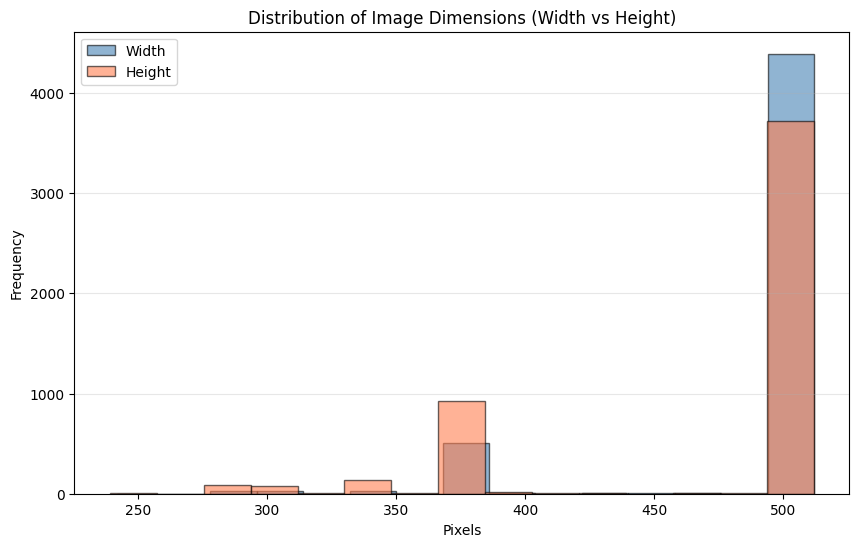

In [ ]:
# Histogram of image dimensions
plt.figure(figsize=(10, 6))
plt.hist(width_size, bins=15, alpha=0.6, label='Width', edgecolor='black', color='steelblue')
plt.hist(height_size, bins=15, alpha=0.6, label='Height', edgecolor='black', color='coral')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions (Width vs Height)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


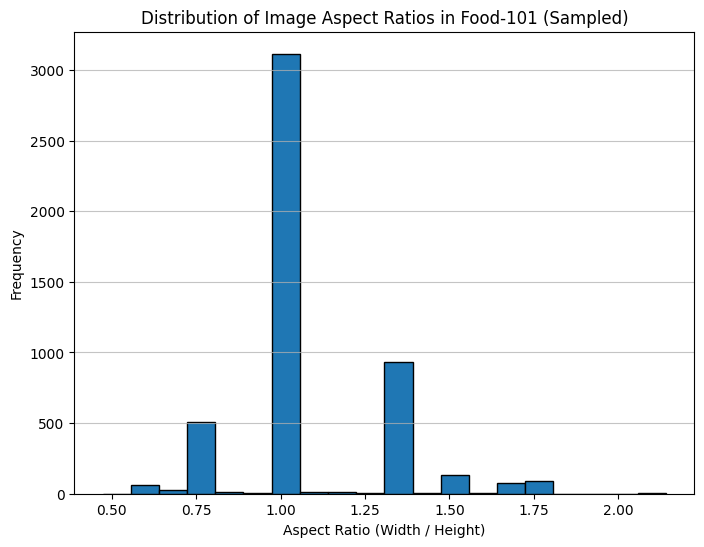

In [ ]:
# Calculate aspect ratios
aspect_ratios = [width / height for width, height in zip(width_size, height_size)]

# Plot a histogram of aspect ratios
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=20, edgecolor='black')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Aspect Ratios in Food-101 (Sampled)')
plt.grid(axis='y', alpha=0.75)
plt.show()

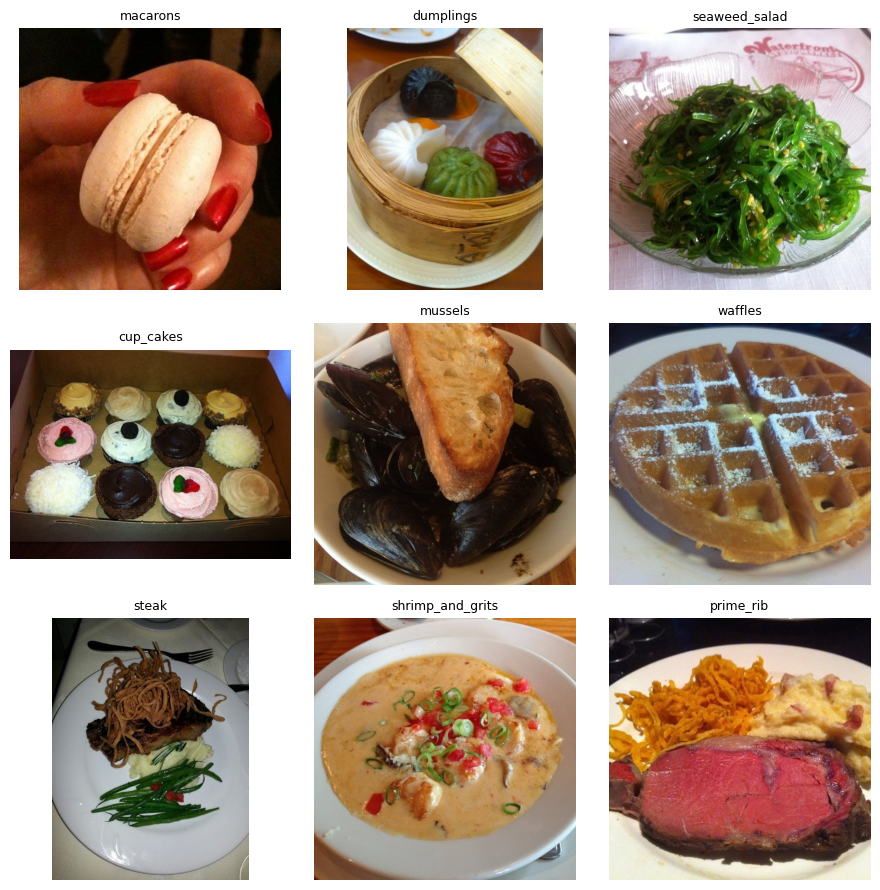

In [ ]:
n, cols, seed = 9, 3, 12
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)

plt.tight_layout()
plt.show()

Analyzing image brightness and lighting variation...


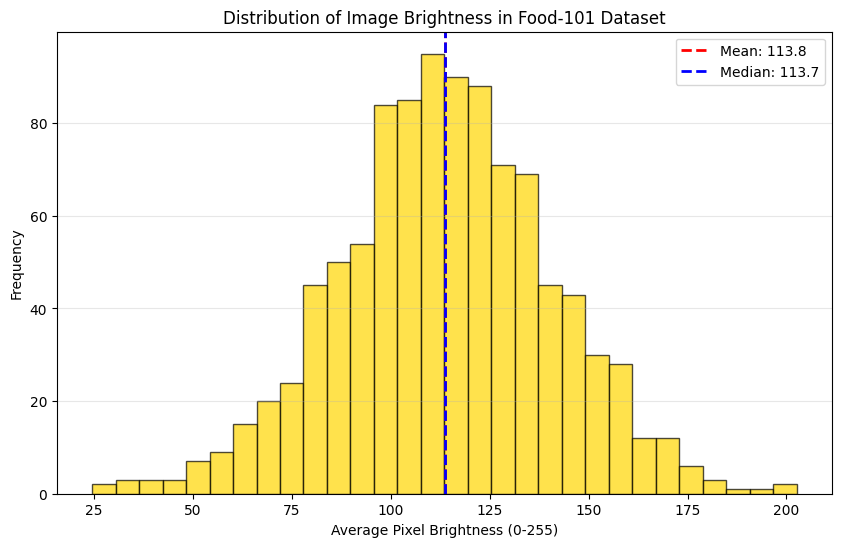


Brightness Statistics (from 1000 samples):
  Mean brightness: 113.84
  Std deviation: 27.02
  Min brightness: 24.61 (very dark)
  Max brightness: 202.58 (very bright)
  Range: 177.97

  → Significant variation confirms need for brightness augmentation during training


In [ ]:
# Analyze brightness distribution to quantify lighting variation
print("Analyzing image brightness and lighting variation...")

sample_brightness = []
sample_indices_brightness = random.sample(range(len(food_all)), 1000)

for i in sample_indices_brightness:
    img_array = np.array(food_all[i]["image"])
    brightness = img_array.mean()  # Average pixel intensity (0-255)
    sample_brightness.append(brightness)

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(sample_brightness, bins=30, edgecolor='black', color='gold', alpha=0.7)
plt.xlabel('Average Pixel Brightness (0-255)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Brightness in Food-101 Dataset')
plt.axvline(x=np.mean(sample_brightness), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {np.mean(sample_brightness):.1f}')
plt.axvline(x=np.median(sample_brightness), color='blue', linestyle='--',
           linewidth=2, label=f'Median: {np.median(sample_brightness):.1f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\nBrightness Statistics (from {len(sample_brightness)} samples):")
print(f"  Mean brightness: {np.mean(sample_brightness):.2f}")
print(f"  Std deviation: {np.std(sample_brightness):.2f}")
print(f"  Min brightness: {np.min(sample_brightness):.2f} (very dark)")
print(f"  Max brightness: {np.max(sample_brightness):.2f} (very bright)")
print(f"  Range: {np.max(sample_brightness) - np.min(sample_brightness):.2f}")
print(f"\n  -> Significant variation confirms need for brightness augmentation during training")


### Graded Questions (2 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Dataset Summary:**  
   Describe your chosen dataset  (as if explaining to your *clueless boss* what you are working on).
   - State which dataset you are going to use.   
   - What kind of data does it contain (images or text)?  
   - How many samples and classes are there?  
   - What is the task you’ll perform (classification into what categories)?
   - What is the potential business use for this dataset?

**Your answer here:**
The Food-101 image dataset is a multi-class classification collection consisting of approximately 101,000 color photographs across 101 distinct food categories. For each of the 101 classes, there are 1,000 images. The primary challenge in working with Food-101 is handling the diverse and sometimes low-quality image properties, which will require techniques like data cleaning and augmentation to build a robust classification model. This dataset is useful for many purposes with the first being that it can be used to help determine nutritional facts. Individuals can simply take a photo of their meal and get important information instantly without having to research every ingredient in the meal. It would be extremely useful for individuals with severe allergies or food restrictions. Also, this dataset can be used for classifying the dishes which then can be used to get detailed instructions of how to create the dish. Individuals may love a dish from a restaurant and want to make it at home.

2. **Initial Observations:**  
   What stood out to you from your EDA?  
   - Did you notice any imbalanced or ambiguous classes?  
   - Any patterns, anomalies, or potential sources of bias?  
   - For images: note any variation in lighting, composition, or color.  
   - For text: mention redundancy, topic overlap, or very short examples.

**Your answer here:**
During the exploratory data analysis phase, a few observations were made. First, the dataset is perfectly balanced with each class having 1000 photos which will help the model give equal importance to all classes. Next, the histogram of image sizes and aspect ratios indicates significant variation. Images have different widths, heights, and aspect ratios. This variation is a potential challenge that will need to be addressed during preprocessing to ensure consistent input for the model. Thirdly, the visual preview of random images shows that they vary widely in lighting and color balance. Some photos are in bright settings while others are in darker environments. This source of variation presents a challenge for the model. The model will need to be robust to these variations, possibly requiring data augmentation techniques during training. Also, some images have more than one food item which may make it difficult to identify the correct class. For example, the prime rib also contains sweet potatoes and bread.

3. **Challenges & Implications:**  
   Based on your inspection, what challenges might affect model performance or training (e.g., imbalance, ambiguous labels, variable quality)?  

   **Your answer here:**
   A big challenge that the model will face is being able to identify the correct class label when there is more than one item in the image. The model might learn patterns that are not important and can lead to misidentifying the image. For example, the prime rib and steak dishes are very similar and may have the same side dish and may make it difficult for the model to distinguish the two. Another challenge is that the images are different in brightness. Since the model learns pixel patterns, high brightness may make it difficult for the model to learn meaningful features. Or with too much darkness, the model may struggle to detect the object and misclassifies it.

4. **Preparation Ideas:**  
   What data-cleaning or preprocessing steps might help address these issues?  
   (You will not implement these yet—just describe what you might do later.)

**Your answer here:**
To address the identified challenges, several preprocessing steps will be essential. First, all images will be resized to a standard dimension of 224x224 pixels to ensure consistent input size for the CNN, regardless of their original resolution. Second, pixel values will be normalized to a range of 0-1 by dividing by 255, which helps stabilize gradient descent during training. Third, data augmentation techniques will be applied during training to improve robustness: random horizontal flips to account for different orientations, random rotations (up to 15 degrees) to handle varied perspectives, random crops to help the model focus on the food rather than background elements, and brightness/contrast adjustments to address lighting variations. For images that are extremely dark or bright, filtering can be done by converting each image to grayscale, measuring the proportion of pixels that are extremely dark or light, and removing those that exceed a defined threshold. Additionally, center cropping during validation and testing will ensure consistent evaluation while avoiding data leakage from augmentation.

5. **Reflection:**  
   - Why did you choose this dataset over the other one?  
   - What makes it more interesting, realistic, or relevant for you?  
   - What do you expect to learn from working with it?

   **Your answer here:**
I chose the Food-101 image dataset because it is exceptionally realistic and challenging. I think it will be interesting to find a way to build a model that can distinguish among 101 visually similar food types. This complexity task requires developing and optimizing advanced deep learning models capable of recognizing little details. Many dishes are very similar but have small differences and it will create an opportunity to learn new techniques. I find this particularly compelling because it offers the  hands-on experience with training convolutional neural networks and managing the computational demands of large-scale classification.

## Problem 2 - Frame the Problem (15 pts)

#### Objective

Identify the **key challenges** in your chosen dataset and outline **practical solutions** you would try, plus how you'll **evaluate** them later.

#### Steps to follow

1. **Diagnose likely challenges (from your EDA):**

   Examples:
   * **Class imbalance:**
     Report label counts and an imbalance ratio (max / median). List any minority classes.
   * **Length/size variance:**
     For text, show length percentiles (50/75/90/95) and estimate truncation rate at candidate `max_text_length`s (e.g., 256/300/512). For images, summarize native resolutions.
   * **Noise/duplicates/leakage:**
     Note empty or malformed items, near-duplicates, and how you would prevent cross-split leakage.
   * **Ambiguous/overlapping labels:**
     Give 2-3 example pairs you expect to be confusable and why.
   * **Compute constraints:**
     Briefly state limits (RAM/GPU/CPU) that might affect batch size, sequence length, or image size.

2. **Map each challenge to a concrete solution plan:**

   Examples:
   * **Imbalance ->** `class_weight` or oversampling; report which one you'd try first and why.
   * **Length/size ->** pick a target `max_text_length` (e.g., 95th percentile) with masking; for images, standardize resize/crop and basic augmentation.
   * **Noise/duplicates ->** dedupe (hash/near-dup), drop empty/very short items, document any relabeling.
   * **Ambiguity ->** consider merging labels (if justified), or add features (bigrams/char-ngrams; simple image augmentations).
   * **Overfitting risk ->** early stopping on your primary metric, dropout/weight decay, freeze-then-finetune plan (for pretrained features).

3. **Explore appropriate evaluation metrics:**

   Examples:
   * **Primary metric:** pick one aligned to your data (e.g., **macro-F1** if imbalanced; accuracy if balanced).
   * **Secondary metric(s):** per-class precision/recall, confusion matrix.
   * **Protocol:** stratified Train/Val/Test (e.g., 70/15/15), fixed seed, leakage checks.

4. **Answer the graded questions below.**



In [ ]:
# ============================================
# Problem 2 Supporting Analysis
# ============================================

# This cell provides quantitative support for the challenges identified in Problem 2
# by analyzing: (1) visual similarity, (2) image resolution variance,
# (3) class balance, and (4) label ambiguity through token overlap

# 1. VISUAL SIMILARITY - Manual identification of confusable pairs
print("=" * 60)
print("1. VISUAL SIMILARITY ANALYSIS")
print("=" * 60)

confusable_pairs = [
    ("ramen", "pho"),
    ("prime_rib", "steak"),
    ("beef_tartare", "tuna_tartare"),
    ("apple_pie", "peach_cobbler"),
    ("caprese_salad", "greek_salad")
]

print("\nExamples of Potentially Confusable Food Pairs:")
for food1, food2 in confusable_pairs:
    if food1 in food_label_names and food2 in food_label_names:
        print(f"  - {food1.replace('_', ' ').title()} vs {food2.replace('_', ' ').title()}")
print("\nThese pairs look visually similar and may cause confusion during classification.")


# 2. IMAGE RESOLUTION SUMMARY
print("\n" + "=" * 60)
print("2. IMAGE RESOLUTION SUMMARY (from 5,000 samples)")
print("=" * 60)
print(f"Average dimensions: {np.mean(width_size):.0f} x {np.mean(height_size):.0f} pixels")
print(f"Width range: {np.min(width_size)} - {np.max(width_size)} pixels")
print(f"Height range: {np.min(height_size)} - {np.max(height_size)} pixels")
print(f"\n-> Solution: Resize all images to 224x224 pixels for CNN input consistency")


# 3. CLASS BALANCE CONFIRMATION
print("\n" + "=" * 60)
print("3. CLASS BALANCE ANALYSIS")
print("=" * 60)
print(f"All classes have exactly 1,000 images (perfectly balanced)")
print(f"Imbalance ratio (max/median): 1.0")
print(f"\n-> Benefit: No need for class weighting or oversampling")


# 4. LABEL AMBIGUITY - Token-based similarity analysis
# Purpose: Identify potentially confused food categories based on shared words in class names
# Approach: Tokenize class names (split on underscores), compute overlap, rank pairs

print("\n" + "=" * 60)
print("4. LABEL AMBIGUITY ANALYSIS (Token Overlap)")
print("=" * 60)

# Create token sets for each class name
tokens_by_label = {name: set(name.split("_")) for name in food_label_names}

# Compute overlap between every pair of classes
token_pairs = []
names = list(tokens_by_label.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        t1, t2 = tokens_by_label[names[i]], tokens_by_label[names[j]]
        overlap = len(t1 & t2)
        if overlap > 0:
            token_pairs.append((names[i], names[j], overlap))

# Sort and display top overlapping pairs
token_pairs_sorted = sorted(token_pairs, key=lambda x: (-x[2], x[0], x[1]))[:15]
print("\nTop 15 Likely Confusable Pairs (by shared label tokens):")
for a, b, ov in token_pairs_sorted:
    print(f"  - {a.replace('_', ' ').title()} vs {b.replace('_', ' ').title()}  (shared={ov} token{'s' if ov > 1 else ''})")

# Token frequency analysis
unique_tokens = Counter(t for toks in tokens_by_label.values() for t in toks)
print("\nMost Common Words Across All Food Labels:")
for token, count in unique_tokens.most_common(10):
    print(f"  {token:15s} appears in {count:>3d} classes")

print("\n" + "=" * 60)
print("SUMMARY: Dataset presents challenges in visual similarity, label")
print("ambiguity, and image quality - all addressable through preprocessing,")
print("augmentation, and transfer learning with deep CNNs.")
print("=" * 60)

1. VISUAL SIMILARITY ANALYSIS

Examples of Potentially Confusable Food Pairs:
  • Ramen vs Pho
  • Prime Rib vs Steak
  • Beef Tartare vs Tuna Tartare
  • Caprese Salad vs Greek Salad

These pairs look visually similar and may cause confusion during classification.

2. IMAGE RESOLUTION SUMMARY (from 5,000 samples)
Average dimensions: 495 x 475 pixels
Width range: 242 - 512 pixels
Height range: 239 - 512 pixels

→ Solution: Resize all images to 224x224 pixels for CNN input consistency

3. CLASS BALANCE ANALYSIS
All classes have exactly 1,000 images (perfectly balanced)
Imbalance ratio (max/median): 1.0

→ Benefit: No need for class weighting or oversampling

4. LABEL AMBIGUITY ANALYSIS (Token Overlap)

Top 15 Likely Confusable Pairs (by shared label tokens):
  • Beef Carpaccio vs Beef Tartare  (shared=1 token)
  • Beef Tartare vs Tuna Tartare  (shared=1 token)
  • Beet Salad vs Caesar Salad  (shared=1 token)
  • Beet Salad vs Caprese Salad  (shared=1 token)
  • Beet Salad vs Greek Salad

### Graded Questions (3 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **State the prediction task**  
   - Describe what your model will predict (the *label*).  
   - *Examples:*  
     - “Given a photo of food, predict which of 101 categories it belongs to.”  
     - “Given a news headline + summary, predict its topical category.”  

**Your answer here:**

The prediction task for the Food-101 dataset is a multi-class image classification challenge. Specifically, the model will be fed an image of a prepared dish and must predict a single label, which is the food category from the 101 distinct classes. In practical terms, if a user uploads a photo of a tuna tartare, the model's goal is to accurately output the label 'tuna_tartare', distinguishing it from the 100 other options like `beef_tartare` or `falafel`.

2. **Define inputs and outputs**  
   - *Inputs:* what information the model receives (e.g., pixel data, tokenized text).  
   - *Outputs:* the categorical label the model will predict.  

**Your answer here:**

For the Food-101 dataset, the inputs and outputs for the image classification model are defined as follows: the input is a digital color image of a prepared food dish, represented as a multi-dimensional array (tensor) containing the pixel data of the image, typically with dimensions such as (Height, Width, 3), where the three channels correspond to the RGB color components. The output is the model's prediction of the specific food category shown in the input image, expressed as a single categorical label (string) selected from the 101 possible food categories (for example, "omelette," "samosa," or "steak").

3. **Identify possible challenges**  
   - Imbalanced classes, noisy data, ambiguous labels, overlapping features, or missing data  
   - *Images:* variation in lighting, color, composition, or size.  
   - *Text:* class imbalance, duplicate stories, short or ambiguous headlines.  

**Your answer here:**

The first challenge involves data quality and variation. Since the dataset is composed of web-scraped images, it includes significant inconsistency in lighting, color balance, and image composition. Some images are overly bright or dark, while others differ in color contrast. Also, the dataset contains images of various sizes and resolutions, which must be standardized for CNN input. Background clutter—such as plates, utensils, tables, and other foods, also adds visual noise, making it harder for the model to focus on the food itself.

A second challenge is ambiguous and overlapping visual features between classes. Many food categories in the dataset look visually similar. For example, ramen and pho or between different grilled meat dishes. This overlap increases the risk of misclassification, as the model must learn to recognize subtle differences in texture, color, and presentation. Furthermore, some dishes like pizza appear in different styles and sizes which can complicate the model's ability to identify patterns.

4. **Propose how you will prepare or improve the data to address the challenges**  
   - *Images:* resizing, normalization, data augmentation (flips, rotations, brightness, color jitter).  
   - *Text:* tokenization, stop-word removal, TF-IDF, class balancing, embeddings (choose an embedding approach and specify its vector size).

**Your answer here:**

To address data quality and variation challenges, preprocessing will include three key steps: (1) resizing all images to a consistent 224x224 pixel dimension to ensure uniform input for the CNN, (2) normalizing pixel values to the 0-1 range to stabilize the learning process, and (3) applying data augmentation during training. Augmentation techniques will include random horizontal flips, rotations up to 15 degrees, random crops, and brightness/contrast adjustments. These transformations help the model learn to recognize food items under different lighting conditions, orientations, and compositions, making it robust to the natural variation in web-scraped images.

To address ambiguous and overlapping features between similar food classes, the solution relies on leveraging deep convolutional neural networks with sufficient capacity to learn fine-grained visual distinctions. Advanced architectures like ResNet or EfficientNet will be employed because they use residual connections and hierarchical feature learning to extract subtle differences in texture, color, and presentation. Transfer learning will be implemented by fine-tuning a model pretrained on ImageNet, allowing the model to leverage learned visual features from a large-scale dataset and adapt them to the specific characteristics of Food-101. This approach significantly reduces training time while improving classification accuracy for visually similar categories.

5. **Specify success metrics**  
   - Identify the metrics you plan to use to evaluate model performance—typically **accuracy** and/or **F1-score**, which are standard for classification tasks.  
   - Briefly explain **why** these metrics are appropriate for your dataset and goal. For instance, accuracy may suffice for well-balanced datasets, while F1-score better reflects performance when some classes are under-represented.
   - If your dataset is **imbalanced**, consider computing **per-class metrics** (e.g., precision, recall, or F1 for each label) or **macro-averaged** scores, which give equal weight to each class regardless of its size—ensuring that minority classes are evaluated fairly.
In some cases, weighted averages (which weight classes by their frequency) or **confusion matrices** can also provide useful insight.
> You haven't run any models yet, and we haven’t studied every possible metric, but you’re encouraged to ask your favorite generative AI tool which evaluation metrics might best fit your dataset!
   - Clearly state how you will interpret success—for example, “Our goal is to achieve at least 80% overall accuracy without large per-class disparities.”

**Your answer here:**

For evaluating the performance of the Food-101 classification model, we will use a combination of metrics appropriate for a balanced multi-class classification problem. Since the dataset is perfectly balanced with 1,000 images per class, **accuracy** will serve as the primary metric, providing a straightforward measure of overall correctness. However, to ensure comprehensive evaluation, we will also compute **macro-averaged Precision, Recall, and F1-Score**, which treat all 101 classes equally regardless of sample size. This ensures that performance is not dominated by any particular category and that the model performs consistently across all food types.

Additionally, a **confusion matrix** will be generated to identify which food pairs are most frequently confused, providing insights into model weaknesses and guiding future improvements. Per-class metrics will help identify any classes that significantly underperform despite the balanced dataset, potentially due to high visual similarity with other classes.

**Success Criteria:** Our goal is to achieve at least **85-90% overall accuracy** with no individual class falling below 70% F1-score. Modern convolutional neural networks with transfer learning (using pretrained models like ResNet50 or EfficientNet on ImageNet) typically achieve 85%+ accuracy on Food-101, making this an ambitious yet realistic target. This ensures that the model performs consistently well across all 101 categories without significant per-class disparities, while accounting for the inherent challenge of distinguishing visually similar food items.

### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**

I used ChatGPT to help me clarify certain machine learning concepts, such as data augmentation, normalization, and CNN architectures.

---

## Appendix: A quick guide to Hugging Face Datasets

#### 1) What are they?

* A **table-like** dataset: rows = examples, columns = named fields (e.g., `"image"`, `"label"`, `"headline"`).
* Backed by **Apache Arrow** → fast, memory-efficient, lazy transforms.
* Two core objects:

  * `Dataset` — one table of rows/columns.
  * `DatasetDict` — a dict of splits, e.g. `{"train": Dataset, "val": Dataset, "test": Dataset}`.


#### 2) Load and inspect

```python
from datasets import load_dataset

# Food-101 (images)
food = load_dataset("food101", split="train+validation")  # both splits at once
len(food), food.column_names, food.features
# -> (≈101000, ['image','label'], {'label': ClassLabel(num_classes=101, names=[...])})

# Access by name (not by numeric column index!)
row0 = food[0]
img0, y0 = row0["image"], row0["label"]     # PIL image, int id
label_names = food.features["label"].names
label_names[y0]
```

For text (HuffPost JSON mirror):

```python
url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff = load_dataset("json", data_files=url, split="train")
huff.column_names  # e.g. ['headline','short_description','category','authors','link','date']
```


#### 3) Common transforms

`Dataset`s are **immutable**: ops return a new dataset.

* **Map** (add/modify columns):

```python
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

huff = huff.map(mk_text)  # adds 'text' column
```

* **Class-encode** labels (strings → integers with a vocabulary):

```python
from datasets.features import ClassLabel
if not isinstance(huff.features["category"], ClassLabel):
    huff = huff.class_encode_column("category")  # now ints with .names
```

* **Filter / select / rename / drop**:

```python
small = huff.select(range(5000))  # first 5k rows
huff = huff.remove_columns(["authors","link","date"])
huff = huff.rename_column("category", "label")
```


#### 4) Splitting & shuffling

```python
# Stratified 80/10/10 on Food-101 by 'label'
from datasets import DatasetDict
label_col = "label"

tmp = food.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=42, stratify_by_column=label_col)
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

len(ds["train"]), len(ds["val"]), len(ds["test"])
```

* `train_test_split` is **random by default** (reproducible with `seed=`).
* You typically **don’t need to pre-shuffle** datasets if your training dataloader already shuffles each epoch.


#### 5) Working with images

Use `with_transform` to apply on-the-fly resizing/augmentation and return tensors:

```python
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch, math, random

IM_SIZE = 224
train_tfms = T.Compose([T.RandomResizedCrop(IM_SIZE), T.RandomHorizontalFlip(), T.ToTensor()])
eval_tfms  = T.Compose([T.Resize(256), T.CenterCrop(IM_SIZE), T.ToTensor()])

def add_pixel_values(ex, tfms):  # ex['image'] -> ex['pixel_values']
    ex = dict(ex); ex["pixel_values"] = tfms(ex["image"]); return ex

train_t = ds["train"].with_transform(lambda ex: add_pixel_values(ex, train_tfms))
val_t   = ds["val"].with_transform(lambda ex: add_pixel_values(ex, eval_tfms))

def collate(batch):
    return {"pixel_values": torch.stack([b["pixel_values"] for b in batch]),
            "labels": torch.tensor([b["label"] for b in batch])}

train_loader = DataLoader(train_t, batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_t,   batch_size=64, shuffle=False, collate_fn=collate)
```

### 6) Working with Text

You can preprocess and tokenize text datasets using either a **transformer tokenizer** or a **linguistic pipeline like spaCy**, depending on your model type and goals.


#### Option A: Transformer Tokenizer (for fine-tuning models like BERT or DistilBERT)

Use a pretrained tokenizer with the Hugging Face `map` method to efficiently process your dataset in batches:

```python
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = huff.map(
    tokenize,
    batched=True,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

This produces token IDs, attention masks, and other fields expected by transformer models.
Use this approach if your project involves fine-tuning pretrained language models.


#### Option B: spaCy Tokenization and Cleaning (for classical ML or custom preprocessing)

If you are **not using transformers**, or if you want to explore feature engineering (e.g., TF-IDF, word frequency, or embedding averages), you can preprocess text with **spaCy** instead.

```python
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS

def spacy_clean(batch):
    docs = list(nlp.pipe(batch["text"], batch_size=1000))
    cleaned = []
    for doc in docs:
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
    return {"text_clean": cleaned, "len_tokens": [len(c.split()) for c in cleaned]}

huff = huff.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

The resulting column `text_clean` can be used with:

* `TfidfVectorizer` (Scikit-learn)
* `TextVectorization` (Keras)
* or any other custom embedding method.

> 💡 **Tip:** spaCy is ideal for lightweight NLP pipelines or for models that rely on explicit preprocessing (lemmatization, stopword removal). Transformer tokenizers, by contrast, expect *raw text* and handle subword tokenization internally.



#### 7) Slicing, concatenating, saving

```python
# Slicing
head_1000 = food.select(range(1000))
tail_10pct = food.select(range(int(0.9*len(food)), len(food)))

# Concatenate splits/datasets
from datasets import concatenate_datasets
all_train = concatenate_datasets([ds["train"], ds["val"]])

# Save / reload
ds.save_to_disk("food101_splits")
from datasets import load_from_disk
ds2 = load_from_disk("food101_splits")
```


#### 8) Quick “gotchas”

* **Columns by name** (strings), not numeric indices.
* Avoid converting huge columns to `list(...)` unless necessary; prefer vectorized ops with `map`, `filter`, `select`.
* `PYTHONHASHSEED` must be set **before** the Python process starts to matter; use explicit `seed=` arguments for reproducibility.
* Datasets print **previews** (e.g., `Column([6, 6, 6, ...])` is just the first few values).


#### 9) A minimal checklist to follow

1. `load_dataset(...)` → confirm `column_names`, `features`.
2. Build any needed columns (`"text"`), and **class-encode** labels if strings.
3. Make a **stratified 80/10/10** split (`train_test_split` ×2).
4. Do **EDA**: class counts, sample printouts or image grids.
5. For training:

   * **images** → `with_transform` + DataLoader
   * **text** → tokenizer via `.map(...)` + trainer/model pipeline
6. Save your `DatasetDict` with `save_to_disk(...)` (optional for text but handy, **don't** use it for big image datasets).

